# Tick Data from LOBSTER

LOBSTER (Limit Order Book System - The Efficient Reconstructor) is an [online](https://lobsterdata.com/info/WhatIsLOBSTER.php) limit order book data tool to provide easy-to-use, high-quality limit order book data.

Since 2013 LOBSTER acts as a data provider for the academic community, giving access to reconstructed limit order book data for the entire universe of NASDAQ traded stocks. 

More recently, it has started to make the data available on a commercial basis.

## Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline
from pathlib import Path
from datetime import datetime, timedelta
from itertools import chain

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
sns.set_style('whitegrid')

## Load Orderbook Data

We will illustrate the functionality using a free sample.

Obtain data here: https://lobsterdata.com/info/DataSamples.php; [this](https://lobsterdata.com/info/sample/LOBSTER_SampleFile_AMZN_2012-06-21_10.zip) is the link to the 10-level file

The code assumes the file has been extracted into a `data` subfolder of the current directory.

In [4]:
path = Path('data')

We use the following to label the table columns:

In [5]:
list(chain(*[('Ask Price {0},Ask Size {0},Bid Price {0},Bid Size {0}'.format(i)).split(',') for i in range(10)]))

['Ask Price 0',
 'Ask Size 0',
 'Bid Price 0',
 'Bid Size 0',
 'Ask Price 1',
 'Ask Size 1',
 'Bid Price 1',
 'Bid Size 1',
 'Ask Price 2',
 'Ask Size 2',
 'Bid Price 2',
 'Bid Size 2',
 'Ask Price 3',
 'Ask Size 3',
 'Bid Price 3',
 'Bid Size 3',
 'Ask Price 4',
 'Ask Size 4',
 'Bid Price 4',
 'Bid Size 4',
 'Ask Price 5',
 'Ask Size 5',
 'Bid Price 5',
 'Bid Size 5',
 'Ask Price 6',
 'Ask Size 6',
 'Bid Price 6',
 'Bid Size 6',
 'Ask Price 7',
 'Ask Size 7',
 'Bid Price 7',
 'Bid Size 7',
 'Ask Price 8',
 'Ask Size 8',
 'Bid Price 8',
 'Bid Size 8',
 'Ask Price 9',
 'Ask Size 9',
 'Bid Price 9',
 'Bid Size 9']

In [6]:
price = list(chain(*[('Ask Price {0},Bid Price {0}'.format(i)).split(',') for i in range(10)]))
size = list(chain(*[('Ask Size {0},Bid Size {0}'.format(i)).split(',') for i in range(10)]))
cols = list(chain(*zip(price, size)))

In [8]:
order_data = 'AMZN_2012-06-21_34200000_57600000_orderbook_10.csv'
orders = pd.read_csv(path / order_data, header=None, names=cols)

In [9]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 269748 entries, 0 to 269747
Data columns (total 40 columns):
 #   Column       Non-Null Count   Dtype
---  ------       --------------   -----
 0   Ask Price 0  269748 non-null  int64
 1   Ask Size 0   269748 non-null  int64
 2   Bid Price 0  269748 non-null  int64
 3   Bid Size 0   269748 non-null  int64
 4   Ask Price 1  269748 non-null  int64
 5   Ask Size 1   269748 non-null  int64
 6   Bid Price 1  269748 non-null  int64
 7   Bid Size 1   269748 non-null  int64
 8   Ask Price 2  269748 non-null  int64
 9   Ask Size 2   269748 non-null  int64
 10  Bid Price 2  269748 non-null  int64
 11  Bid Size 2   269748 non-null  int64
 12  Ask Price 3  269748 non-null  int64
 13  Ask Size 3   269748 non-null  int64
 14  Bid Price 3  269748 non-null  int64
 15  Bid Size 3   269748 non-null  int64
 16  Ask Price 4  269748 non-null  int64
 17  Ask Size 4   269748 non-null  int64
 18  Bid Price 4  269748 non-null  int64
 19  Bid Size 4   269748 non

In [10]:
orders.head()

,Ask Price 0,Ask Size 0,Bid Price 0,Bid Size 0,Ask Price 1,Ask Size 1,Bid Price 1,Bid Size 1,Ask Price 2,Ask Size 2,...,Bid Price 7,Bid Size 7,Ask Price 8,Ask Size 8,Bid Price 8,Bid Size 8,Ask Price 9,Ask Size 9,Bid Price 9,Bid Size 9
0,2239500,100,2231800,100,2239900,100,2230700,200,2240000,220,...,2202500,5000,2294300,100,2202000,100,2298000,100,2189700,100
1,2239500,100,2238100,21,2239900,100,2231800,100,2240000,220,...,2204000,100,2294300,100,2202500,5000,2298000,100,2202000,100
2,2239500,100,2238100,21,2239600,20,2231800,100,2239900,100,...,2204000,100,2267700,100,2202500,5000,2294300,100,2202000,100
3,2239500,100,2238100,21,2239600,20,2237500,100,2239900,100,...,2213000,4000,2267700,100,2204000,100,2294300,100,2202500,5000
4,2239500,100,2238100,21,2239600,20,2237500,100,2239900,100,...,2213000,4000,2267700,100,2204000,100,2294300,100,2202500,5000


## Parse Message Data

Message Type Codes:

    1: Submission of a new limit order
    2: Cancellation (Partial deletion 
       of a limit order)
    3: Deletion (Total deletion of a limit order)
    4: Execution of a visible limit order			   	 
    5: Execution of a hidden limit order
    7: Trading halt indicator 				   
       (Detailed information below)

In [11]:
types = {1: 'submission',
         2: 'cancellation',
         3: 'deletion',
         4: 'execution_visible',
         5: 'execution_hidden',
         7: 'trading_halt'}

In [12]:
trading_date = '2012-06-21'
levels = 10

In [13]:
message_data = 'AMZN_{}_34200000_57600000_message_{}.csv'.format(
    trading_date, levels)
messages = pd.read_csv(path / message_data,
                       header=None,
                       names=['time', 'type', 'order_id', 'size', 'price', 'direction'])
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 269748 entries, 0 to 269747
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   time       269748 non-null  float64
 1   type       269748 non-null  int64  
 2   order_id   269748 non-null  int64  
 3   size       269748 non-null  int64  
 4   price      269748 non-null  int64  
 5   direction  269748 non-null  int64  
dtypes: float64(1), int64(5)
memory usage: 12.3 MB


In [14]:
messages.head()

,time,type,order_id,size,price,direction
0,34200.017460,5,0,1,2238200,-1
1,34200.189608,1,11885113,21,2238100,1
2,34200.189608,1,3911376,20,2239600,-1
3,34200.189608,1,11534792,100,2237500,1
4,34200.189608,1,1365373,13,2240000,-1


Around 80% of executions were visible, the remaining 20% were not:

In [15]:
messages.type.map(types).value_counts()

submission           131954
deletion             123458
execution_visible      8974
cancellation           2917
execution_hidden       2445
Name: type, dtype: int64

In [16]:
messages.time = pd.to_timedelta(messages.time, unit='s')
messages['trading_date'] = pd.to_datetime(trading_date)
messages.time = messages.trading_date.add(messages.time)
messages.drop('trading_date', axis=1, inplace=True)
messages.head()

,time,type,order_id,size,price,direction
0,2012-06-21 09:30:00.017459617,5,0,1,2238200,-1
1,2012-06-21 09:30:00.189607670,1,11885113,21,2238100,1
2,2012-06-21 09:30:00.189607670,1,3911376,20,2239600,-1
3,2012-06-21 09:30:00.189607670,1,11534792,100,2237500,1
4,2012-06-21 09:30:00.189607670,1,1365373,13,2240000,-1


## Combine message and price data

In [17]:
data = pd.concat([messages, orders], axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 269748 entries, 0 to 269747
Data columns (total 46 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   time         269748 non-null  datetime64[ns]
 1   type         269748 non-null  int64         
 2   order_id     269748 non-null  int64         
 3   size         269748 non-null  int64         
 4   price        269748 non-null  int64         
 5   direction    269748 non-null  int64         
 6   Ask Price 0  269748 non-null  int64         
 7   Ask Size 0   269748 non-null  int64         
 8   Bid Price 0  269748 non-null  int64         
 9   Bid Size 0   269748 non-null  int64         
 10  Ask Price 1  269748 non-null  int64         
 11  Ask Size 1   269748 non-null  int64         
 12  Bid Price 1  269748 non-null  int64         
 13  Bid Size 1   269748 non-null  int64         
 14  Ask Price 2  269748 non-null  int64         
 15  Ask Size 2   269748 non-null  int6

In [18]:
ex = data[data.type.isin([4, 5])]

In [19]:
ex.head()

,time,type,order_id,size,price,direction,Ask Price 0,Ask Size 0,Bid Price 0,Bid Size 0,...,Bid Price 7,Bid Size 7,Ask Price 8,Ask Size 8,Bid Price 8,Bid Size 8,Ask Price 9,Ask Size 9,Bid Price 9,Bid Size 9
0,2012-06-21 09:30:00.017459617,5,0,1,2238200,-1,2239500,100,2231800,100,...,2202500,5000,2294300,100,2202000,100,2298000,100,2189700,100
32,2012-06-21 09:30:00.190226476,4,11885113,21,2238100,1,2239500,100,2237500,100,...,2230400,100,2244900,100,2230000,10,2245000,5,2226200,100
33,2012-06-21 09:30:00.190226476,4,11534792,26,2237500,1,2239500,100,2237500,74,...,2230400,100,2244900,100,2230000,10,2245000,5,2226200,100
37,2012-06-21 09:30:00.372779672,5,0,100,2238400,-1,2239500,100,2237500,74,...,2226200,100,2244900,100,2213000,4000,2245000,5,2204000,100
38,2012-06-21 09:30:00.375671205,5,0,100,2238400,-1,2239500,100,2237500,74,...,2226200,100,2244900,100,2213000,4000,2245000,5,2204000,100


## Plot limit order prices for messages with visible or hidden execution

In [20]:
cmaps = {'Bid': 'Blues','Ask': 'Reds'}

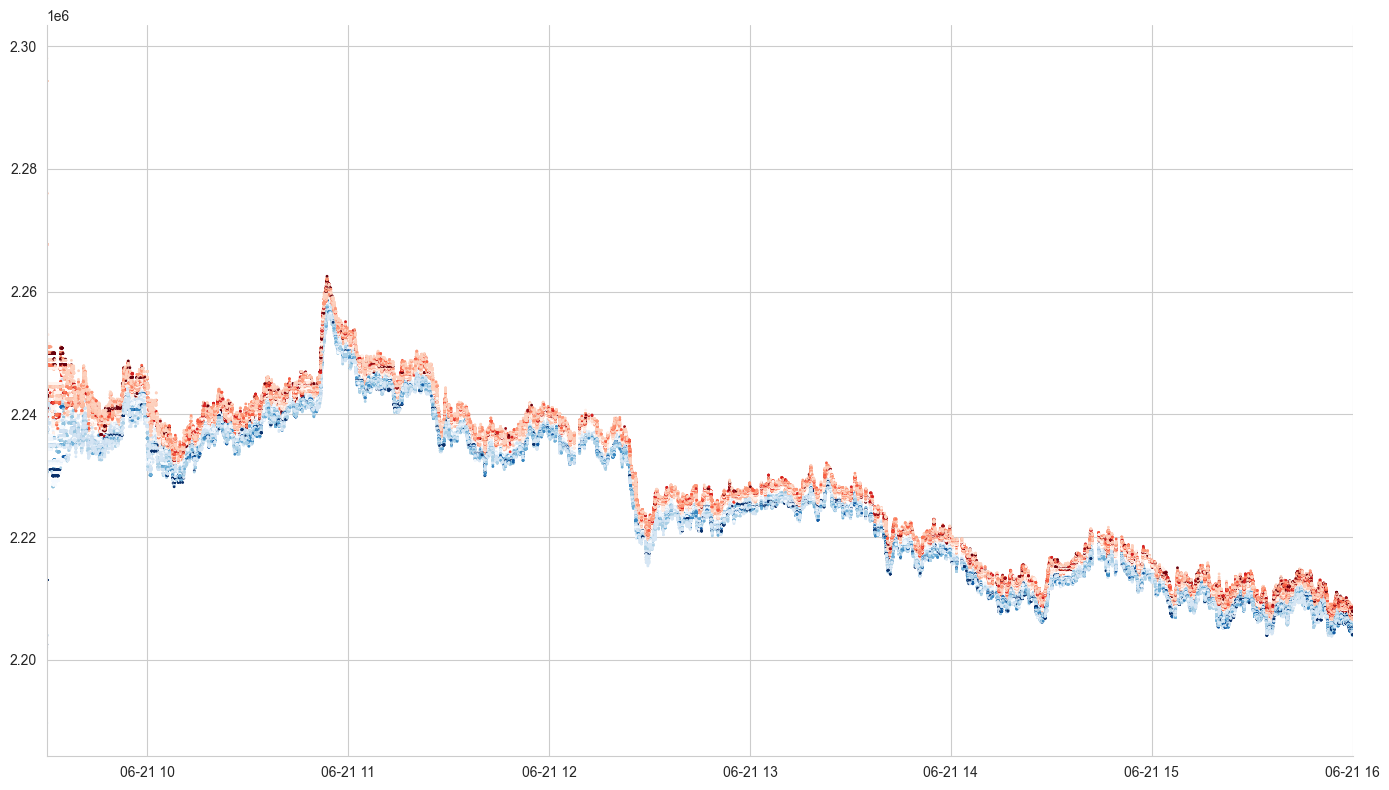

In [21]:
fig, ax=plt.subplots(figsize=(14, 8))
time = ex['time'].dt.to_pydatetime()
for i in range(10):
    for t in ['Bid', 'Ask']:
        y, c = ex['{} Price {}'.format(t, i)], ex['{} Size {}'.format(t, i)]
        ax.scatter(x=time, y=y, c=c, cmap=cmaps[t], s=1, vmin=1, vmax=c.quantile(.95))
ax.set_xlim(datetime(2012, 6, 21, 9, 30), datetime(2012, 6, 21, 16, 0))
sns.despine()
fig.tight_layout();

## Plot prices for all order types

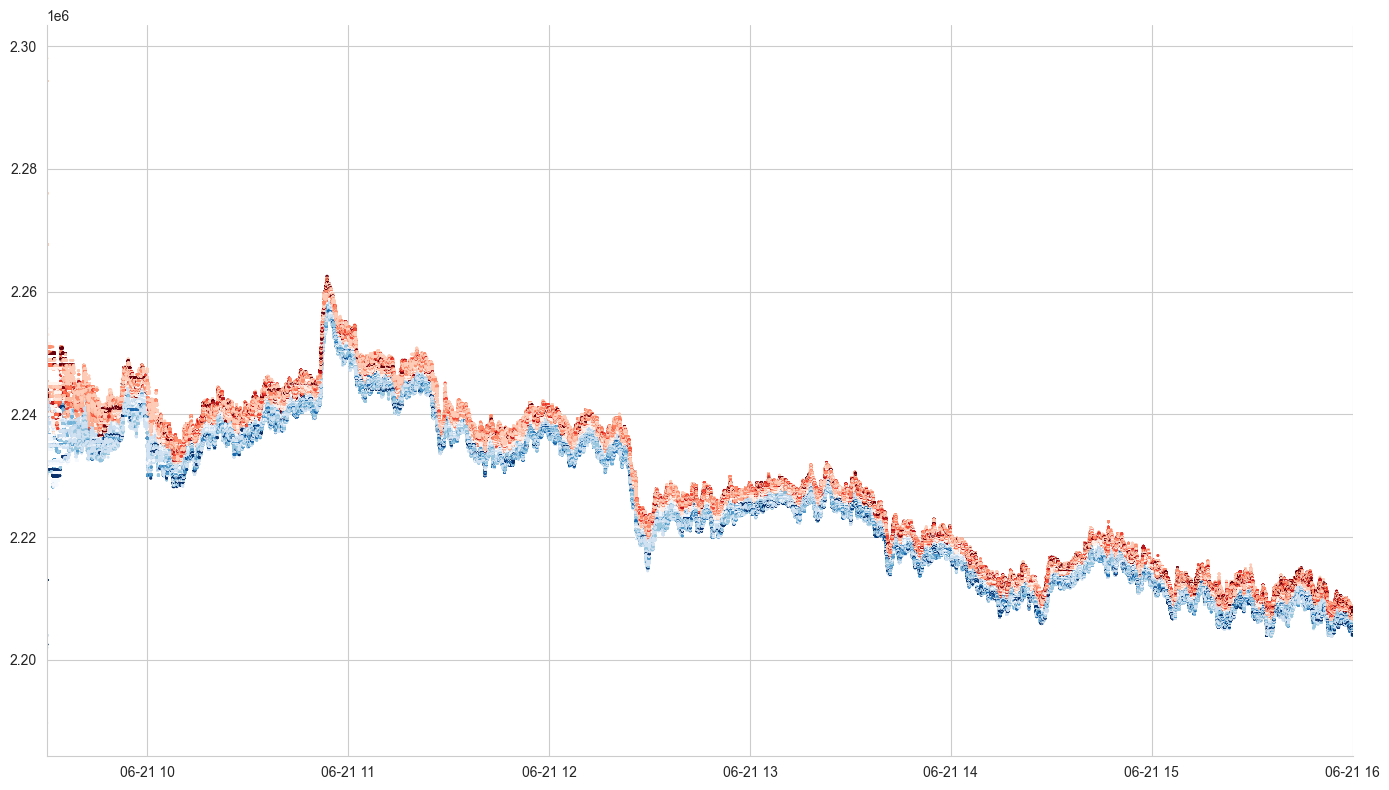

In [22]:
fig, ax=plt.subplots(figsize=(14, 8))
time = data['time'].dt.to_pydatetime()
for i in range(10):
    for t in ['Bid', 'Ask']:
        y, c = data['{} Price {}'.format(t, i)], data['{} Size {}'.format(t, i)]
        ax.scatter(x=time, y=y, c=c, cmap=cmaps[t], s=1, vmin=1, vmax=c.quantile(.95))
ax.set_xlim(datetime(2012, 6, 21, 9, 30), datetime(2012, 6, 21, 16, 0))
sns.despine()
fig.tight_layout();